## Changepoint detection
#### Lauren Olivia Guerra Hernández C-412 
#### guerralauren44@gmail.com

### Question 1:
#### Simulate a time series with n = 500 realizations distributed according to a probability distribution L of your choice. This time series should have K∗ ≥ 2 changes in one or more dimensions of the parameters of L (you set the value of K∗ as desired). Plot this time series.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import random 

#### Simuated time serie with normal distribution

[ 92 405]


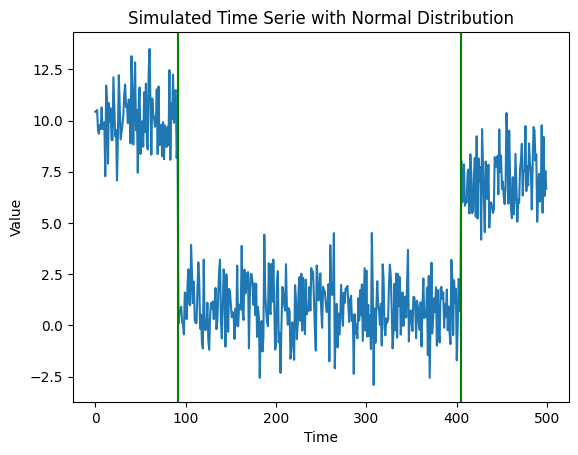

In [320]:
n = 500
K_star = 2
change_points_n = np.sort(np.random.choice(n, K_star, replace=False))
means = np.concatenate([np.random.normal(10, 1, change_points_n[0]),
                        np.random.normal(1, 1, change_points_n[1] - change_points_n[0]),
                        np.random.normal(7, 1, n - change_points_n[1])])
ts_normal = np.random.normal(means, 1)
print(change_points_n)
plt.plot(ts_normal)
plt.title('Simulated Time Serie with Normal Distribution')
plt.xlabel('Time')
for i in change_points_n:
    plt.axvline(x=i, color='green')
plt.ylabel('Value')
plt.show()

#### Simulate a time series with exponential distribution

[ 15 210]
[9, 1, 15]


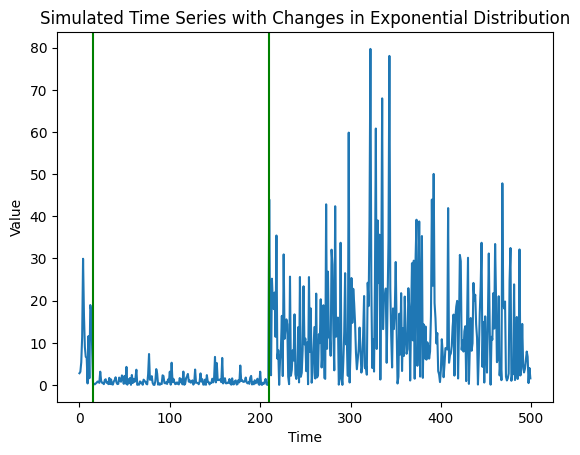

In [258]:
import numpy as np
import matplotlib.pyplot as plt


n = 500
K_star = 2
change_points = np.sort(np.random.choice(n, K_star, replace=False))

lambdas = [random.randint(1, 10) for i in range(K_star + 1)] #np.random.uniform(-1, 3, K_star + 1)
lambdas = [9, 1, 15]

print (change_points)
print (lambdas)
time_serie = [*np.random.exponential(lambdas[0], change_points[0]), 
              *np.random.exponential(lambdas[1], change_points[1] - change_points[0]),
              *np.random.exponential(lambdas[2], n - change_points[1])]



# Plot time series
plt.plot(time_serie)
for i in change_points:
    plt.axvline(x=i, color='green')
plt.title('Simulated Time Series with Changes in Exponential Distribution')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

##### For the rest of the questions, we will use the time series with an exponential distribution because better results were obtained with it.

### Question 2:
#### Derive a suitable cost function for the simulated data in Question 1. Briefly justify your choice (in a comment in your code).


#### La función de costo utilizada es la siguiente:

$c(y_a:b)=-(b-a) \lambda_{MLE} + \lambda_{MLE} \sum ^{L} _{i-a}y_i$

$\lambda_{MLE}=(b-a)/ \sum ^b _{i=a} y_i$

This cost function is good because it is able to fit a wide variety of probability distributions, such as exponential and normal, allowing modeling of a wide range of time series. It is easy to implement and compute, making it useful for practical applications in time series modeling. It penalizes model complexity (number of parameters b-a) which helps to avoid overfitting. It takes large values when the interval is heterogeneous and small values when it is homogeneous, so in a heterogeneous interval, there is a high probability of a change point occurring.


In [115]:
def lam(y: list[float], a: int, b: int):
    return (b-a) / np.sum(y[a:b])


def cost_function(y: list[float], a: int, b: int):
    return -(b-a) * lam(y, a, b) + lam(y, a, b) * np.sum(y[a:b])


### Question 3:
#### Implement the optimal partitioning algorithm and test it on the simulated data in Question 1.


#### The optimal partition algorithm was implemented following the pseudocode presented in the conference.

In [246]:
def get_min_arg(k,M,M1,s):    
    s = int(s)
    args = {t:(M[k-1, 0, t] + M1[t+1, s-1]) for t in range(k-1,s-1)}
    return min(args, key=lambda k:args[k])

def optimal_partition(y, c, K):
    n = len(y)
    M = np.zeros((K,n,n))
    for u in range(0, n-1):
        for v in range(u+1, n):
            M[0][u, v] = c(y, u, v)
    if K > 0:
        for k in range(1,K):
            for u in range(n):
                for v in range(u+k, n):     
                    M[k][u,v] = min(M[k-1][u,t] + M[0][t+1, v] for t in range(u+k-1,v))
    
    L = np.zeros(K+1)
    L[K] = n
    k = K
    while k>0:     
        s = L[k]
        t_star = get_min_arg(k,M,M[0],s)
        L[k-1] = t_star
        k=k-1
    return L[:K]

change points values [ 14. 203.]


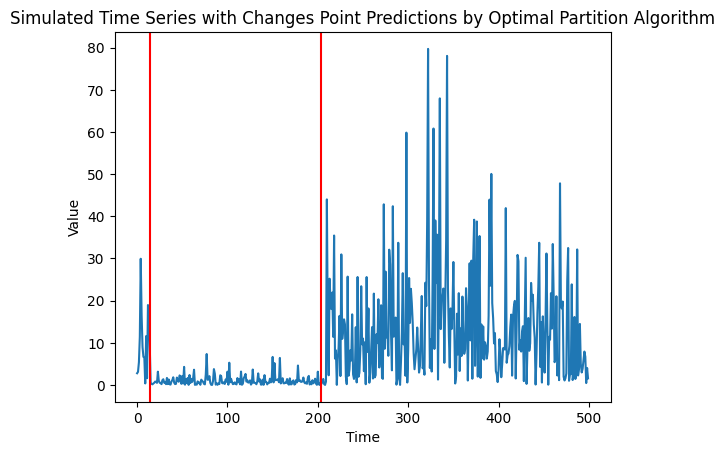

In [259]:
y = time_serie
K = K_star
c = cost_function
change_points_predict = optimal_partition(y,c,K)
print("change points values",change_points_predict)
plt.plot(y)
for i in change_points_predict:
    plt.axvline(x=i, color='red')
plt.title('Simulated Time Series with Changes Point Predictions by Optimal Partition Algorithm')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

### Question 4:
#### Implement the PELT algorithm and test it using the simulated data in Question 1. You will set the value of the penalty weight as log(n).


In [293]:
def pelt(y, c, beta, nmin=10):
    n = len(y)
    F = [-beta] * n
    R = [0]
    CP = [None] * (n+1)
    CP[0] = []
    for t in range(nmin+1, n):
        F_t = [F[r] + c(y,r+1,t+1) + beta for r in R if abs(t-r)>=nmin]
        t_star = R[np.argmin(F_t)]
        F[t] = min(F_t)
        CP[t] = CP[t_star] + [t_star]
        R_new = [r for r in R if F[r]+c(y,r+1,t+1)+beta <= F[t]]
        R_new.append(t)
        R = R_new
    CP[n] = CP[R[0]] + [R[0]]
    return CP[n]

change points values [16, 209] 2


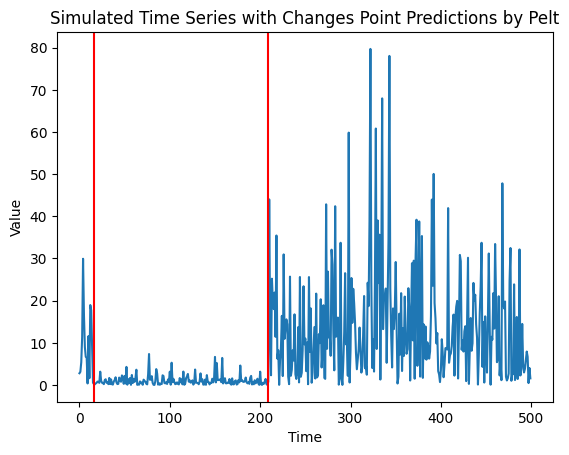

In [294]:
import math
y=time_serie
change_points_pelt = pelt(y,c,math.log(n),10)[1:]
print("change points values",change_points_pelt, len(change_points_pelt))
plt.plot(y)
for i in change_points_pelt:
    plt.axvline(x=i, color='red')
plt.title('Simulated Time Series with Changes Point Predictions by PELT')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

### Question 5:
#### Test the PELT algorithm with other values of the penalty weight. Comment on the results.

39


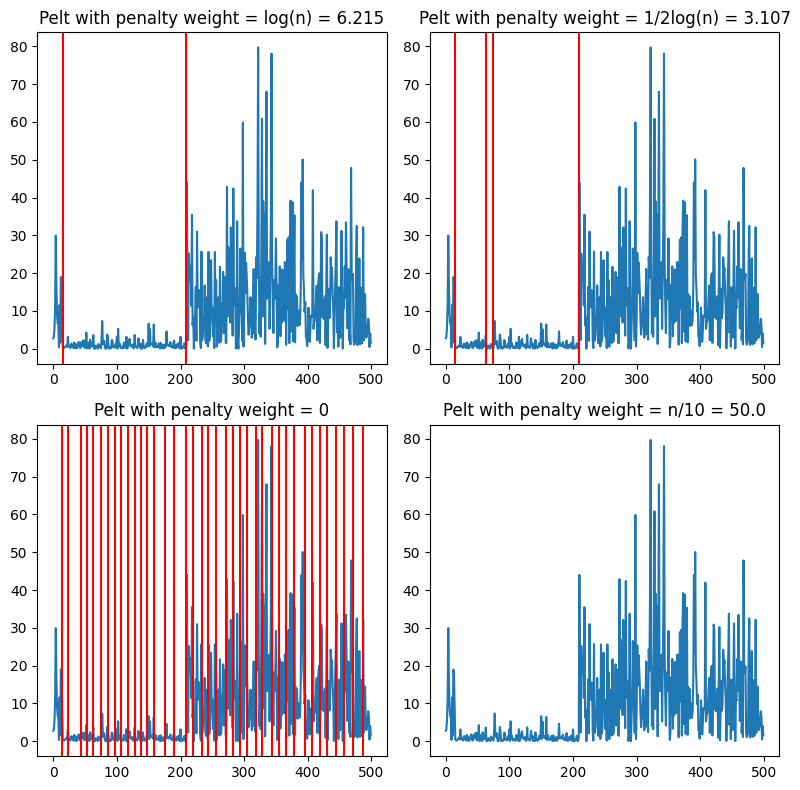

In [319]:
penalty_weight = math.log(n)
penalty_weight1 = 1/2 * math.log(n)
penalty_weight2 = 0
penalty_weight3 = n/10


fig, axs = plt.subplots(2, 2, figsize=(8, 8))


cp = pelt(y, c, penalty_weight)[1:]
axs[0, 0].plot(y)
for i in cp:
    axs[0, 0].axvline(x=i, color='red')
axs[0, 0].plot()
axs[0, 0].set_title(f'PELT with penalty weight = log(n) = {round(penalty_weight, 3)}')


cp1 = pelt(y, c, penalty_weight1)[1:]
axs[0, 1].plot(y)
for i in cp1:
    axs[0, 1].axvline(x=i, color='red')
axs[0, 1].plot()
axs[0, 1].set_title(f'PELT with penalty weight = 1/2log(n) = {round(penalty_weight1, 3)}')


cp2 = pelt(y, c, penalty_weight2)[1:]
axs[1, 0].plot(y)
for i in cp2:
    axs[1, 0].axvline(x=i, color='red')
axs[1, 0].plot( )
axs[1, 0].set_title(f'PELT with penalty weight = {penalty_weight2}')


cp3 = pelt(y, c, penalty_weight3)[1:]
axs[1,1].plot(y)
for i in cp3:
    axs[1,1].axvline(x=i, color='red')
axs[1,1].plot( )
axs[1,1].set_title(f'PELT with penalty weight = n/10 = {penalty_weight3}')

plt.tight_layout()
plt.show()


For this specific time series, very good results are obtained using the penalty weight $\beta=log(n)$. Other cases were tested with $\beta=1/2log(n)$, which is also widely used in the literature, but for this case it gives two additional changepoints that are not correctly located. For the value 0, which represents no penalty weight, 39 changepoints are found, which is much higher than the actual number of changepoints present. For very large values, such as n/10 = 50, no changepoints are found.

The choice of the appropriate penalty weight value will depend on the nature of the data and the analysis objective. For small penalty weight values, the PELT algorithm allows for greater complexity in the model partition, which can lead to overfitting and the detection of many changepoints. Conversely, when the penalty weight has large values, the PELT algorithm is more restrictive in the complexity of the model, which can lead to bias in the model partition and the omission of important changes in the time series, resulting in fewer changepoints, and in some cases, none at all depending on the size and nature of the data. Therefore, selecting the appropriate penalty weight value is crucial for obtaining an accurate and useful model partition.